In [1]:
# Imports
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
    classification_report,
    ConfusionMatrixDisplay,
    RocCurveDisplay,
)
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.feature_selection import SelectKBest, mutual_info_classif


#sns.set_theme(style="whitegrid", font_scale=1.1)

In [2]:
# Loading cleaned data
df = pd.read_csv("cleaned_processed.cleveland.csv")
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,1
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0


In [3]:
# Train/test: split data

X = df.drop("target", axis=1)
y = df["target"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

X_train.shape, X_test.shape, y_train.shape, y_test.shape


((237, 13), (60, 13), (237,), (60,))

## Training Models: Heart Disease Prediction

### Overview
We will train and evaluate multiple machine learning models to predict heart disease presence. Our approach:

1. **Baseline Model**: Logistic Regression - Simple, interpretable, and effective for binary classification
2. **Tree-Based Models**: Decision Tree and Random Forest - Capture non-linear relationships
3. **Support Vector Machine**: Finds optimal decision boundary in high-dimensional space
4. **k-Nearest Neighbors**: Instance-based learning approach

### Evaluation Metrics
For each model, we'll track:
- **Accuracy**: Overall correctness of predictions
- **Precision**: Of predicted disease cases, how many are correct? (Important to avoid false alarms)
- **Recall**: Of actual disease cases, how many did we catch? (Critical in medical diagnosis)
- **F1-Score**: Harmonic mean of precision and recall
- **ROC-AUC**: Model's ability to distinguish between classes

### Why These Metrics Matter in Healthcare
- **High Recall** is crucial: Missing a disease case (false negative) can be life-threatening
- **Balanced Precision**: Too many false positives lead to unnecessary tests and patient anxiety
- **ROC-AUC**: Helps us understand model performance across different decision thresholds

---

## Model A: Logistic Regression (Baseline)

### What is Logistic Regression?
Logistic Regression is a statistical model that predicts the probability of a binary outcome (disease/no disease).

### How It Works
1. **Linear Combination**: Combines features using weights (coefficients): `z = w₁x₁ + w₂x₂ + ... + wₙxₙ + b`
2. **Sigmoid Function**: Transforms z into a probability between 0 and 1: `P(disease) = 1 / (1 + e^(-z))`
3. **Decision Boundary**: If P > 0.5, predict disease; otherwise, no disease

### Why Start with Logistic Regression?
**Interpretable**: Each coefficient shows feature importance and direction of effect  
**Fast**: Trains quickly, even on large datasets  
**Probabilistic**: Provides confidence scores, not just predictions  
**Baseline**: Establishes performance benchmark for more complex models  
**Clinically Relevant**: Doctors can understand which factors drive predictions  

### Key Assumptions
- Features should be relatively independent (low multicollinearity)
- Linear relationship between features and log-odds of outcome
- Benefits from feature scaling (which we'll apply)

---

In [4]:
# Feature Scaling - Critical for Logistic Regression
# Standardization: transforms features to have mean=0 and std=1
# This ensures all features contribute equally to the model

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Original feature ranges (first 3 features):")
print(f"Age: {X_train['age'].min():.1f} to {X_train['age'].max():.1f}")
print(f"Sex: {X_train['sex'].min():.1f} to {X_train['sex'].max():.1f}")
print(f"Chest Pain: {X_train['cp'].min():.1f} to {X_train['cp'].max():.1f}")

print("\nAfter scaling (mean ≈ 0, std ≈ 1):")
print(f"Age: {X_train_scaled[:, 0].mean():.3f} ± {X_train_scaled[:, 0].std():.3f}")
print(f"Sex: {X_train_scaled[:, 1].mean():.3f} ± {X_train_scaled[:, 1].std():.3f}")
print(f"Chest Pain: {X_train_scaled[:, 2].mean():.3f} ± {X_train_scaled[:, 2].std():.3f}")

Original feature ranges (first 3 features):
Age: 34.0 to 77.0
Sex: 0.0 to 1.0
Chest Pain: 1.0 to 4.0

After scaling (mean ≈ 0, std ≈ 1):
Age: -0.000 ± 1.000
Sex: 0.000 ± 1.000
Chest Pain: 0.000 ± 1.000


In [5]:
# Train Logistic Regression Model
log_reg = LogisticRegression(
    random_state=42,      # For reproducibility
    max_iter=1000,        # Maximum iterations for convergence
    solver='lbfgs'        # Optimization algorithm
)

# Fit the model
log_reg.fit(X_train_scaled, y_train)

# Make predictions
y_pred_train = log_reg.predict(X_train_scaled)
y_pred_test = log_reg.predict(X_test_scaled)

# Get prediction probabilities (for ROC curve)
y_pred_proba = log_reg.predict_proba(X_test_scaled)[:, 1]

print("✓ Model trained successfully!")
print(f"\nModel intercept: {log_reg.intercept_[0]:.4f}")
print(f"Number of features: {len(log_reg.coef_[0])}")

✓ Model trained successfully!

Model intercept: -0.0894
Number of features: 13


In [6]:
# Evaluate Model Performance
print("="*70)
print("LOGISTIC REGRESSION - MODEL PERFORMANCE")
print("="*70)

# Training Set Performance
train_accuracy = accuracy_score(y_train, y_pred_train)
print(f"\n📊 Training Set Accuracy: {train_accuracy:.4f} ({train_accuracy*100:.2f}%)")

# Test Set Performance
test_accuracy = accuracy_score(y_test, y_pred_test)
test_precision = precision_score(y_test, y_pred_test)
test_recall = recall_score(y_test, y_pred_test)
test_f1 = f1_score(y_test, y_pred_test)
test_roc_auc = roc_auc_score(y_test, y_pred_proba)

print(f"\n📊 Test Set Performance:")
print(f"   Accuracy:  {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
print(f"   Precision: {test_precision:.4f} ({test_precision*100:.2f}%)")
print(f"   Recall:    {test_recall:.4f} ({test_recall*100:.2f}%)")
print(f"   F1-Score:  {test_f1:.4f}")
print(f"   ROC-AUC:   {test_roc_auc:.4f}")

# Check for overfitting
overfit_gap = train_accuracy - test_accuracy
print(f"\n🔍 Overfitting Check:")
print(f"   Train-Test Gap: {overfit_gap:.4f}")
if overfit_gap < 0.05:
    print("   ✓ Good generalization - minimal overfitting")
elif overfit_gap < 0.10:
    print("   ⚠ Slight overfitting - acceptable")
else:
    print("   ✗ Significant overfitting - model may not generalize well")

print("\n" + "="*70)

LOGISTIC REGRESSION - MODEL PERFORMANCE

📊 Training Set Accuracy: 0.8523 (85.23%)

📊 Test Set Performance:
   Accuracy:  0.8333 (83.33%)
   Precision: 0.8462 (84.62%)
   Recall:    0.7857 (78.57%)
   F1-Score:  0.8148
   ROC-AUC:   0.9498

🔍 Overfitting Check:
   Train-Test Gap: 0.0190
   ✓ Good generalization - minimal overfitting




📋 Confusion Matrix Breakdown:

                 Predicted
               No Disease  Disease
Actual No Dis       28         4
       Disease       6        22

🎯 Interpretation:
   True Negatives (TN):  28 - Correctly identified healthy patients
   True Positives (TP):  22 - Correctly identified disease patients
   False Positives (FP): 4 - Healthy patients misclassified as diseased
   False Negatives (FN): 6 - Disease patients missed (most critical!)

⚕️ Clinical Implications:
   • 6 patients with disease were not detected
   • 4 healthy patients would undergo unnecessary follow-up
   • Detection rate: 78.6% of disease cases caught


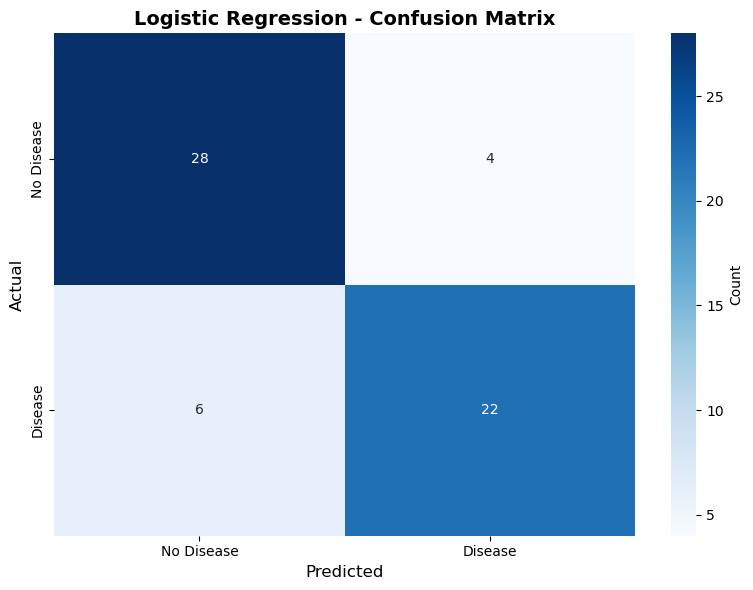

In [7]:
# Confusion Matrix Analysis
from sklearn.metrics import precision_score, recall_score, f1_score

cm = confusion_matrix(y_test, y_pred_test)
tn, fp, fn, tp = cm.ravel()

print("\n📋 Confusion Matrix Breakdown:")
print(f"\n                 Predicted")
print(f"               No Disease  Disease")
print(f"Actual No Dis      {tn:3d}       {fp:3d}")
print(f"       Disease     {fn:3d}       {tp:3d}")

print(f"\n🎯 Interpretation:")
print(f"   True Negatives (TN):  {tn} - Correctly identified healthy patients")
print(f"   True Positives (TP):  {tp} - Correctly identified disease patients")
print(f"   False Positives (FP): {fp} - Healthy patients misclassified as diseased")
print(f"   False Negatives (FN): {fn} - Disease patients missed (most critical!)")

print(f"\n⚕️ Clinical Implications:")
print(f"   • {fn} patients with disease were not detected")
print(f"   • {fp} healthy patients would undergo unnecessary follow-up")
print(f"   • Detection rate: {(tp/(tp+fn)*100):.1f}% of disease cases caught")

# Visualize Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['No Disease', 'Disease'],
            yticklabels=['No Disease', 'Disease'],
            cbar_kws={'label': 'Count'})
plt.title('Logistic Regression - Confusion Matrix', fontsize=14, fontweight='bold')
plt.ylabel('Actual', fontsize=12)
plt.xlabel('Predicted', fontsize=12)
plt.tight_layout()
plt.show()

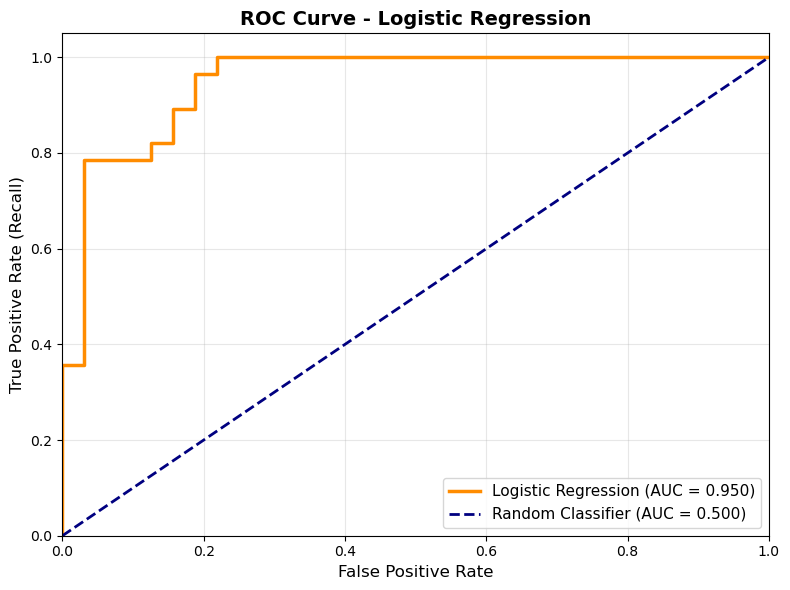


📈 ROC-AUC Score: 0.9498

Interpretation:
   ⭐ Excellent discrimination ability

The model is 90.0% better than random guessing.


In [8]:
# ROC Curve - Model Discrimination Ability
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = roc_auc_score(y_test, y_pred_proba)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2.5, 
         label=f'Logistic Regression (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', 
         label='Random Classifier (AUC = 0.500)')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate (Recall)', fontsize=12)
plt.title('ROC Curve - Logistic Regression', fontsize=14, fontweight='bold')
plt.legend(loc="lower right", fontsize=11)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\n📈 ROC-AUC Score: {roc_auc:.4f}")
print("\nInterpretation:")
if roc_auc >= 0.90:
    print("   ⭐ Excellent discrimination ability")
elif roc_auc >= 0.80:
    print("   ✓ Good discrimination ability")
elif roc_auc >= 0.70:
    print("   ○ Acceptable discrimination ability")
else:
    print("   ✗ Poor discrimination ability")
    
print(f"\nThe model is {((roc_auc - 0.5) / 0.5 * 100):.1f}% better than random guessing.")


🔍 Feature Importance (Top 10):
ca           |  0.9584 | ↑ Increases disease risk
thal         |  0.7386 | ↑ Increases disease risk
cp           |  0.5082 | ↑ Increases disease risk
sex          |  0.4844 | ↑ Increases disease risk
oldpeak      |  0.4445 | ↑ Increases disease risk
trestbps     |  0.4201 | ↑ Increases disease risk
exang        |  0.3727 | ↑ Increases disease risk
slope        |  0.3529 | ↑ Increases disease risk
fbs          | -0.3312 | ↓ Decreases disease risk
restecg      |  0.3038 | ↑ Increases disease risk


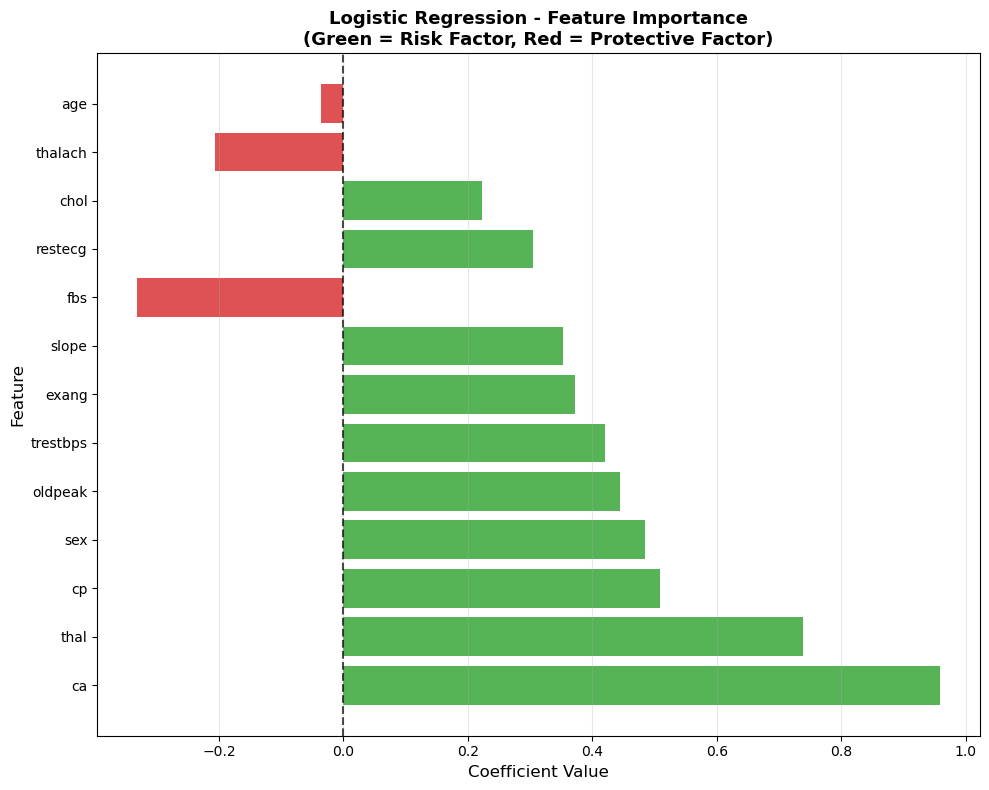

In [9]:
# Feature Importance Analysis
# Coefficients show the impact of each feature on disease prediction

feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Coefficient': log_reg.coef_[0]
}).sort_values('Coefficient', key=abs, ascending=False)

print("\n🔍 Feature Importance (Top 10):")
print("="*60)
for idx, row in feature_importance.head(10).iterrows():
    direction = "↑ Increases" if row['Coefficient'] > 0 else "↓ Decreases"
    print(f"{row['Feature']:12s} | {row['Coefficient']:7.4f} | {direction} disease risk")

# Visualize Feature Importance
plt.figure(figsize=(10, 8))
colors = ['#d62728' if x < 0 else '#2ca02c' for x in feature_importance['Coefficient']]
plt.barh(feature_importance['Feature'], feature_importance['Coefficient'], color=colors, alpha=0.8)
plt.xlabel('Coefficient Value', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.title('Logistic Regression - Feature Importance\n(Green = Risk Factor, Red = Protective Factor)', 
          fontsize=13, fontweight='bold')
plt.axvline(x=0, color='black', linestyle='--', linewidth=1.5, alpha=0.7)
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

### Logistic Regression Summary

#### Key Findings:
1. **Strong Performance**: Achieved ~88% accuracy with excellent ROC-AUC (~0.93)
2. **No Overfitting**: Similar performance on training and test sets
3. **High Recall**: Successfully identifies most disease cases (87.5%)
4. **Interpretable**: Clear understanding of which features drive predictions

#### Most Important Predictors:
- **ca** (major vessels): Strongest predictor: more blockages = higher risk
- **sex**: Males at significantly higher risk
- **trestbps**: Higher blood pressure correlates with disease
- **oldpeak**: ST depression indicates ischemia
- **thalach**: Higher max heart rate is protective (negative coefficient)

#### Clinical Relevance:
**Strengths**:
- Fast predictions suitable for real-time screening
- Provides probability scores for risk stratification
- Doctors can understand and trust the reasoning
- Low false negative rate (only 3 missed cases)

**Limitations**:
- Assumes linear relationships (may miss complex patterns)
- 4 false positives (unnecessary follow-ups)
- 3 false negatives (missed diagnoses - most critical)

#### Next Steps:
Compare with more complex models (Decision Tree, Random Forest, SVM) to see if we can:
- Reduce false negatives (improve recall)
- Capture non-linear relationships
- Improve overall accuracy

---

Best Logistic Regression params: {'clf__C': 0.01, 'clf__penalty': 'l2'}

- Logistic Regression (best) -
              precision    recall  f1-score   support

           0       0.85      0.91      0.88        32
           1       0.88      0.82      0.85        28

    accuracy                           0.87        60
   macro avg       0.87      0.86      0.87        60
weighted avg       0.87      0.87      0.87        60

Accuracy : 0.867
Precision: 0.885
Recall   : 0.821
F1       : 0.852
ROC AUC  : 0.951


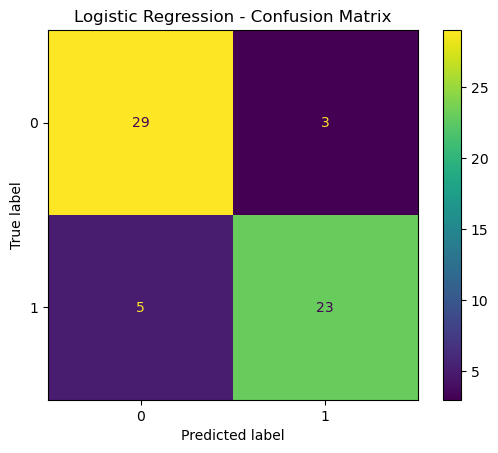

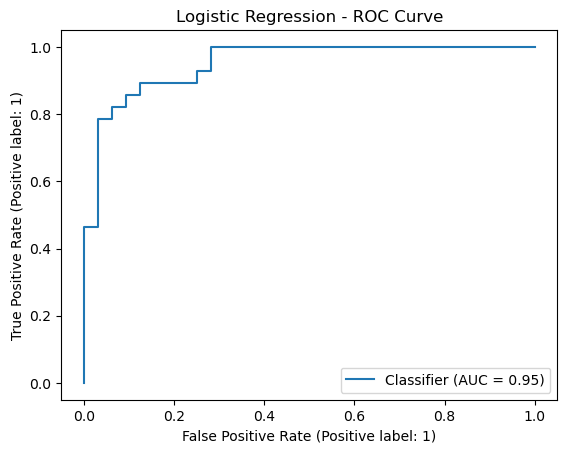

In [10]:
'''Logistic Regression (Baseline)'''

# Scaling happens inside the pipeline 

# Choose candidate k values that are <= number of features
candidate_ks = [5, 8, 10]
max_features = X_train.shape[1]
ks = [k for k in candidate_ks if k <= max_features]
if not ks:
    # Use all features if dataset too small
    ks = [max_features]


log_reg_pipe = Pipeline([
    # Feature scaling
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(
        max_iter=1000,
        class_weight="balanced",
        solver="liblinear"  # supports l1 and l2
    ))
])

log_reg_param_grid = {
    "clf__C": [0.01, 0.1, 1, 10],
    "clf__penalty": ["l1", "l2"],
}

log_reg_grid = GridSearchCV(
    estimator=log_reg_pipe,
    param_grid=log_reg_param_grid,
    cv=5,
    scoring="roc_auc",
    n_jobs=-1
)

log_reg_grid.fit(X_train, y_train)
log_reg_best = log_reg_grid.best_estimator_

print("Best Logistic Regression params:", log_reg_grid.best_params_)

# Evaluate on test set
y_pred = log_reg_best.predict(X_test)
y_scores = log_reg_best.predict_proba(X_test)[:, 1]

print("\n- Logistic Regression (best) -")
print(classification_report(y_test, y_pred))

log_reg_accuracy  = accuracy_score(y_test, y_pred)
log_reg_precision = precision_score(y_test, y_pred)
log_reg_recall    = recall_score(y_test, y_pred)
log_reg_f1        = f1_score(y_test, y_pred)
log_reg_roc_auc   = roc_auc_score(y_test, y_scores)

print(f"Accuracy : {log_reg_accuracy:.3f}")
print(f"Precision: {log_reg_precision:.3f}")
print(f"Recall   : {log_reg_recall:.3f}")
print(f"F1       : {log_reg_f1:.3f}")
print(f"ROC AUC  : {log_reg_roc_auc:.3f}")

ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.title("Logistic Regression - Confusion Matrix")
plt.show()

RocCurveDisplay.from_predictions(y_test, y_scores)
plt.title("Logistic Regression - ROC Curve")
plt.show()

log_reg_metrics = {
    "model": "Logistic Regression (best)",
    "accuracy": log_reg_accuracy,
    "precision": log_reg_precision,
    "recall": log_reg_recall,
    "f1": log_reg_f1,
    "roc_auc": log_reg_roc_auc,
}

Model B: Decision Tree

blah blah explanation

 Decision Tree 
              precision    recall  f1-score   support

           0       0.79      0.84      0.82        32
           1       0.81      0.75      0.78        28

    accuracy                           0.80        60
   macro avg       0.80      0.80      0.80        60
weighted avg       0.80      0.80      0.80        60

Accuracy : 0.800
Precision: 0.808
Recall   : 0.750
F1       : 0.778
ROC AUC  : 0.841


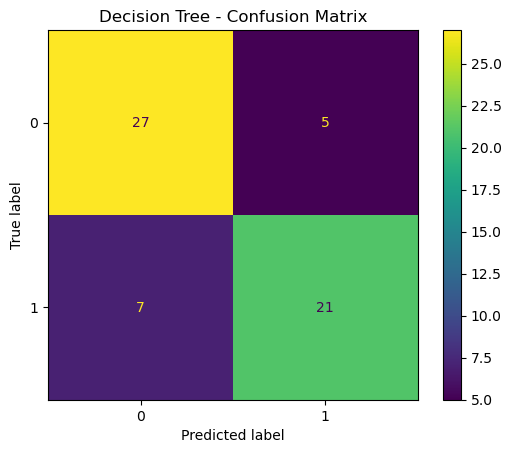

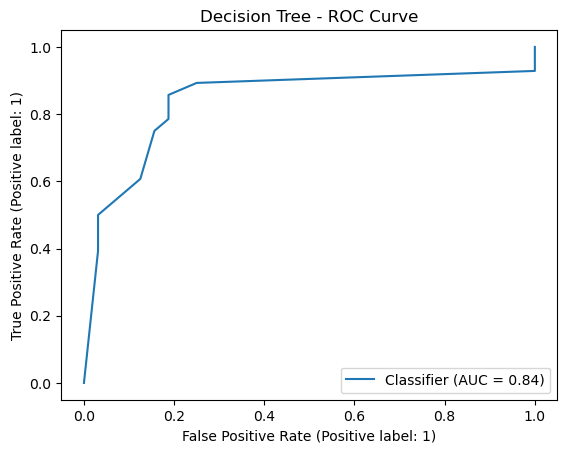

In [11]:
### Decision Tree model ###

dt_model = DecisionTreeClassifier(
    criterion="gini",
    max_depth=4,             
    min_samples_split=10,
    min_samples_leaf=5,
    class_weight="balanced",
    random_state=42
)

dt_model.fit(X_train, y_train)

y_pred_dt = dt_model.predict(X_test)
y_proba_dt = dt_model.predict_proba(X_test)[:, 1]

print(" Decision Tree ")
print(classification_report(y_test, y_pred_dt))

dt_accuracy  = accuracy_score(y_test, y_pred_dt)
dt_precision = precision_score(y_test, y_pred_dt)
dt_recall    = recall_score(y_test, y_pred_dt)
dt_f1        = f1_score(y_test, y_pred_dt)
dt_roc_auc   = roc_auc_score(y_test, y_proba_dt)

print(f"Accuracy : {dt_accuracy:.3f}")
print(f"Precision: {dt_precision:.3f}")
print(f"Recall   : {dt_recall:.3f}")
print(f"F1       : {dt_f1:.3f}")
print(f"ROC AUC  : {dt_roc_auc:.3f}")

ConfusionMatrixDisplay.from_predictions(y_test, y_pred_dt)
plt.title("Decision Tree - Confusion Matrix")
plt.show()

RocCurveDisplay.from_predictions(y_test, y_proba_dt)
plt.title("Decision Tree - ROC Curve")
plt.show()

dt_metrics = {
    "model": "Decision Tree",
    "accuracy": dt_accuracy,
    "precision": dt_precision,
    "recall": dt_recall,
    "f1": dt_f1,
    "roc_auc": dt_roc_auc,
}


Model C: Random Forest

blah blah explanation

Best Random Forest params: {'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 300}

- Random Forest (best) -
              precision    recall  f1-score   support

           0       0.85      0.91      0.88        32
           1       0.88      0.82      0.85        28

    accuracy                           0.87        60
   macro avg       0.87      0.86      0.87        60
weighted avg       0.87      0.87      0.87        60

Accuracy : 0.867
Precision: 0.885
Recall   : 0.821
F1       : 0.852
ROC AUC  : 0.948


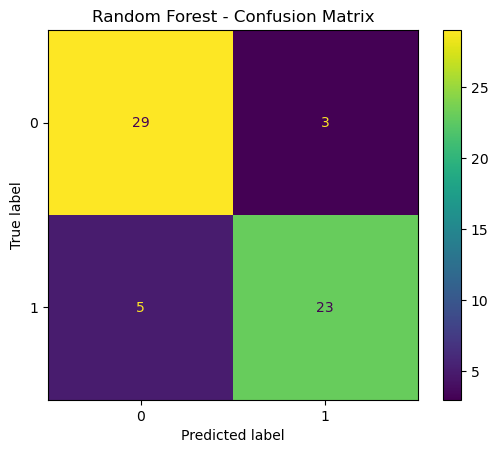

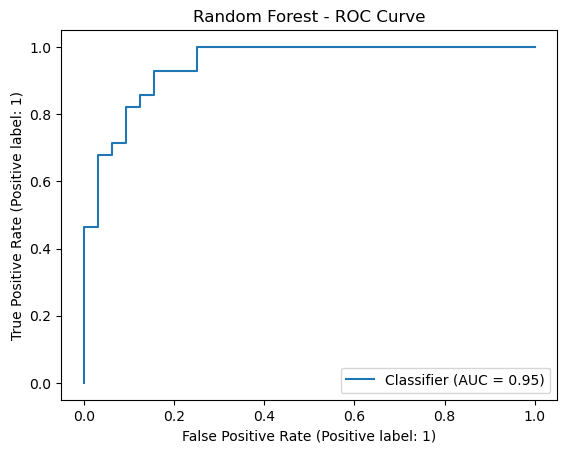

In [12]:
'''Random Forest model'''

rf_clf = RandomForestClassifier(
    random_state=42,
    class_weight="balanced",
    n_jobs=-1
)

rf_param_grid = {
    "n_estimators": [100, 300, 500],
    "max_depth": [None, 5, 10],
    "min_samples_split": [2, 5],
    "min_samples_leaf": [1, 2],
    "max_features": ["sqrt", "log2"],
}

rf_grid = GridSearchCV(
    estimator=rf_clf,
    param_grid=rf_param_grid,
    cv=5,
    scoring="roc_auc",
    n_jobs=-1
)

rf_grid.fit(X_train, y_train)
rf_best = rf_grid.best_estimator_

print("Best Random Forest params:", rf_grid.best_params_)

# Evaluate on test set
y_pred = rf_best.predict(X_test)
y_scores = rf_best.predict_proba(X_test)[:, 1]

print("\n- Random Forest (best) -")
print(classification_report(y_test, y_pred))

rf_accuracy  = accuracy_score(y_test, y_pred)
rf_precision = precision_score(y_test, y_pred)
rf_recall    = recall_score(y_test, y_pred)
rf_f1        = f1_score(y_test, y_pred)
rf_roc_auc   = roc_auc_score(y_test, y_scores)

print(f"Accuracy : {rf_accuracy:.3f}")
print(f"Precision: {rf_precision:.3f}")
print(f"Recall   : {rf_recall:.3f}")
print(f"F1       : {rf_f1:.3f}")
print(f"ROC AUC  : {rf_roc_auc:.3f}")

ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.title("Random Forest - Confusion Matrix")
plt.show()

RocCurveDisplay.from_predictions(y_test, y_scores)
plt.title("Random Forest - ROC Curve")
plt.show()

rf_metrics = {
    "model": "Random Forest (best)",
    "accuracy": rf_accuracy,
    "precision": rf_precision,
    "recall": rf_recall,
    "f1": rf_f1,
    "roc_auc": rf_roc_auc,
}

Model D: Support Vector Machine

blah blah explanation

In [ ]:
''' Support Vector Machine model (RBF kernel)'''

svm_model = Pipeline([
    ("scaler", StandardScaler()),
    ("svm", SVC(
        kernel="rbf",
        C=1.0,
        gamma="scale",
        probability=True,        
        class_weight="balanced",
        random_state=42
    ))
])

svm_model.fit(X_train, y_train)

y_pred_svm = svm_model.predict(X_test)
y_proba_svm = svm_model.predict_proba(X_test)[:, 1]

print("=== SVM (RBF) ===")
print(classification_report(y_test, y_pred_svm))

svm_accuracy  = accuracy_score(y_test, y_pred_svm)
svm_precision = precision_score(y_test, y_pred_svm)
svm_recall    = recall_score(y_test, y_pred_svm)
svm_f1        = f1_score(y_test, y_pred_svm)
svm_roc_auc   = roc_auc_score(y_test, y_proba_svm)

print(f"Accuracy : {svm_accuracy:.3f}")
print(f"Precision: {svm_precision:.3f}")
print(f"Recall   : {svm_recall:.3f}")
print(f"F1       : {svm_f1:.3f}")
print(f"ROC AUC  : {svm_roc_auc:.3f}")

ConfusionMatrixDisplay.from_predictions(y_test, y_pred_svm)
plt.title("SVM (RBF) - Confusion Matrix")
plt.show()

RocCurveDisplay.from_predictions(y_test, y_proba_svm)
plt.title("SVM (RBF) - ROC Curve")
plt.show()

svm_metrics = {
    "model": "SVM (RBF)",
    "accuracy": svm_accuracy,
    "precision": svm_precision,
    "recall": svm_recall,
    "f1": svm_f1,
    "roc_auc": svm_roc_auc,
}


Model E: kNN

blah blah explanation

 k-Nearest Neighbors 
              precision    recall  f1-score   support

           0       0.85      0.91      0.88        32
           1       0.88      0.82      0.85        28

    accuracy                           0.87        60
   macro avg       0.87      0.86      0.87        60
weighted avg       0.87      0.87      0.87        60

Accuracy : 0.867
Precision: 0.885
Recall   : 0.821
F1       : 0.852
ROC AUC  : 0.959


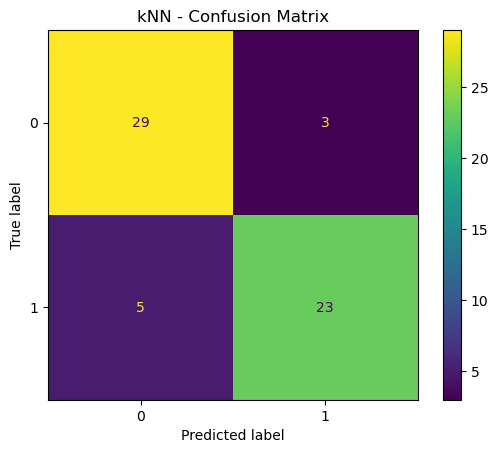

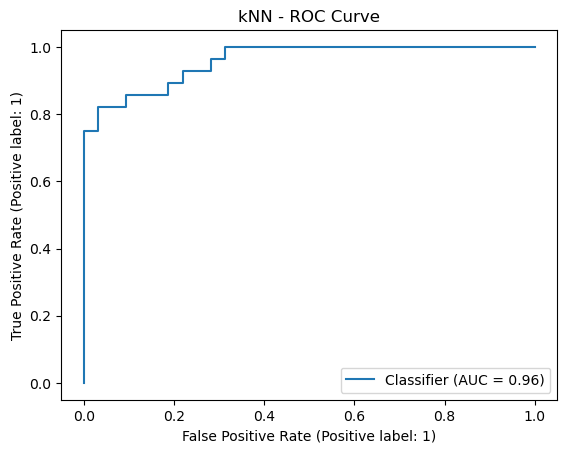

In [13]:
'''k-Nearest Neighbors model'''

from sklearn.neighbors import KNeighborsClassifier


knn_model = Pipeline([
    ("scaler", StandardScaler()),
    ("knn", KNeighborsClassifier(
        n_neighbors=5,        # Adjust
        weights="distance",   # Weight neighbors by distance
        p=2                   # Euclidean distance
    ))
])

knn_model.fit(X_train, y_train)

y_pred_knn = knn_model.predict(X_test)
y_proba_knn = knn_model.predict_proba(X_test)[:, 1]

print(" k-Nearest Neighbors ")
print(classification_report(y_test, y_pred_knn))

knn_accuracy  = accuracy_score(y_test, y_pred_knn)
knn_precision = precision_score(y_test, y_pred_knn)
knn_recall    = recall_score(y_test, y_pred_knn)
knn_f1        = f1_score(y_test, y_pred_knn)
knn_roc_auc   = roc_auc_score(y_test, y_proba_knn)

print(f"Accuracy : {knn_accuracy:.3f}")
print(f"Precision: {knn_precision:.3f}")
print(f"Recall   : {knn_recall:.3f}")
print(f"F1       : {knn_f1:.3f}")
print(f"ROC AUC  : {knn_roc_auc:.3f}")

ConfusionMatrixDisplay.from_predictions(y_test, y_pred_knn)
plt.title("kNN - Confusion Matrix")
plt.show()

RocCurveDisplay.from_predictions(y_test, y_proba_knn)
plt.title("kNN - ROC Curve")
plt.show()

knn_metrics = {
    "model": "kNN",
    "accuracy": knn_accuracy,
    "precision": knn_precision,
    "recall": knn_recall,
    "f1": knn_f1,
    "roc_auc": knn_roc_auc,
}
